In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

In [2]:
# Метод прогонки
def tridiagonal_matrix_algorithm(a, b, c, d, n):
    
    for i in range(1, n):
        coef = a[i]/b[i-1]
        b[i] -= coef * c[i-1]
        d[i] -= coef * d[i-1]
    
    for i in range(n - 1, 0, -1):
        coef = c[i-1]/b[i]
        d[i - 1] -= d[i] * coef
    
    return [d[i] / b[i] for i in range(n)]

def get_gamma(Dom, Ran):
    n = len(Dom)
    
    # шаг сетки
    h = np.array([Dom[i] - Dom[i-1] for i in range(1, n)])
    h = np.hstack((np.array([0]), h))

    a = np.array([h[i]/6 for i in range(2, n - 1)])
    a = np.hstack((np.array([0]), a))
    
    b = np.array([(h[i] + h[i+1])/3 for i in range(1, n - 1)])
    
    c = np.array([h[i+1]/6 for i in range(1, n- 2)])
    c = np.hstack((c, np.array([0])))
    
    d = np.array([(Ran[i+1] - Ran[i])/h[i+1] - (Ran[i] - Ran[i-1])/h[i] for i in range(1, n-1)])
    

    gamma = tridiagonal_matrix_algorithm(a, b, c, d, n-2)
    gamma.insert(0, 0)
    gamma.append(0)
    return gamma

In [3]:
# Функции
f = lambda x: 1/(1 + x**2)
g = lambda x: 1/(1 + e**(-x))
h = lambda x: 1/(5 - tan(x))
t = lambda x: 1/(1+x)

# Участки
Df = np.arange(-2, 5)
Ef = np.array([f(t) for t in Df])
Dg = np.arange(0, 10)
Eg = np.array([g(x) for x in Dg])
Dh = np.arange(-2, 5)
Eh = np.array([h(x) for x in Dh])
Dt = np.arange(0, 10)
Et = np.array([t(x) for x in Dt])

# полином
def Q(i, x, Dom, Ran):
    gamma = get_gamma(Dom, Ran)
    h = [0] + [Dom[i] - Dom[i-1] for i in range(1, len(Dom))]
    p1 = Ran[i - 1]*(Dom[i] - x)/h[i]
    p2 = gamma[i-1]*((Dom[i] - x)**3 - (Dom[i] - x)*h[i]**2)/(6 * h[i])
    p3 = Ran[i]*(x - Dom[i - 1])/h[i]
    p4 = gamma[i]*((x - Dom[i-1])**3 - (x - Dom[i-1])*h[i]**2)/(6*h[i])
    return p1 + p2 + p3 + p4

def get_coef(i, Dom, Ran):
    gamma = get_gamma(Dom, Ran)
    h = [0] + [Dom[i] - Dom[i-1] for i in range(1, len(Dom))]
    a3 = (gamma[i] - gamma[i-1])/(6*h[i])
    a2 = (gamma[i-1] * Dom[i] - gamma[i] * Dom[i - 1])/(2 * h[i])
    a1 = (gamma[i] * Dom[i - 1] ** 2 - gamma[i - 1] * Dom[i] ** 2)/(2 * h[i]) + (Ran[i] - Ran[i - 1])/h[i] - h[i] * (gamma[i] - gamma[i-1]) / 6
    a0 = (gamma[i-1] * Dom[i]**3 - gamma[i] * Dom[i-1] ** 3)/(6*h[i]) + (Ran[i-1] * Dom[i] - Ran[i] * Dom[i - 1])/h[i] + h[i]*(gamma[i] * Dom[i - 1] - gamma[i - 1] * Dom[i]) / 6
    return [a3, a2, a1, a0]

def P(i, x, Dom, Ran):
    a3, a2, a1, a0 = get_coef(i, Dom, Ran)
    return a3 * x**3 + a2 * x**2 + a1 * x + a0

def print_polys(Dom, Ran, name):
    print('Polynom\'s spline of {name}:')
    for i in range(1, len(Dom)):
        a3, a2, a1, a0 = get_coef(i)
        print(f'P_{i}(x) = {a3}x^3 + {a2}x^2 + {a1}x + {a0}, if {Dom[i-1]}<=x<={Dom[i]}')

# cплайн
def spline(x, Dom, Ran):    
    for i in range(1, len(Dom)):
        if ((i == 1) and (Dom[0] <= x <= Dom[1])) or (Dom[i-1] < x <= Dom[i]):
            return P(i, x, Dom, Ran)

In [4]:
def get_intersection(D1, E1, N, D2, E2, M):
    if (D2[0] <= D1[N - 1]) or (D1[0] <= D2[N - 1]):
        flag = False
        for i in range(1, N):
            for j in range(1, M):
                left_border = max(D1[i - 1], D2[j - 1])
                right_border = min(D1[i], D2[j])
                if left_border <= right_border:
                    a = get_coef(i, D1, E1)
                    b = get_coef(j, D2, E2)
                    roots = np.roots([c-d for c, d in zip(a, b)])
                    for root in roots:
                        if -0.08 < root.imag < 0.08 and (left_border<=root.real<=right_border):
                            print(root.real, spline(root.real, D1, E1))
                            flag = True
                            break
                    if flag:
                        break
            if flag:
                break

In [5]:
get_intersection(Df, Ef, len(Df), Dg, Eg, len(Eg))

0.7261679127238079 0.6735957496615668


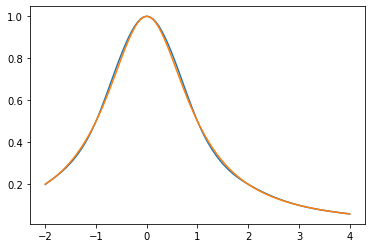

In [7]:
Of = np.linspace(Df[0], Df[6], 100)
plt.plot(Of, [spline(x, Df, Ef) for x in Of])
plt.plot(Of, [f(x) for x in Of])
plt.show()